## 1. Import Libraries and Set Device

In [ ]:
# ========== Standard Libraries ==========
import csv
import os
import time
import warnings
from datetime import datetime
import random

# ========== Data Handling & ML ==========
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# ========== Deep Learning (PyTorch) ==========
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# ========== Image Processing & Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# ========== Utilities ==========
from tqdm import tqdm
import joblib


In [ ]:
# Set the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Using {device} device")
print(f"CUDA Available: {torch.cuda.is_available()}")

# If CUDA is available, print additional details
if torch.cuda.is_available():
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

## 2. Data Loading and Preprocessing

In [ ]:
root_dir = "lung_colon_image_set"
image_paths = []
multi_labels = []

label_mapping = {
    'lung_n': 0, 'lung_aca': 1, 'lung_scc': 2,
    'colon_n': 3, 'colon_aca': 4
}

class_names = list(label_mapping.keys())

for subfolder in ['lung_image_sets/lung_n', 'lung_image_sets/lung_aca', 'lung_image_sets/lung_scc',
                  'colon_image_sets/colon_n', 'colon_image_sets/colon_aca']:
    class_dir = os.path.join(root_dir, subfolder)
    class_name = subfolder.split('/')[-1]

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        multi_labels.append(label_mapping[class_name])

print(f"Total Image: {len(image_paths)}")


In [ ]:
indices = random.sample(range(len(image_paths)), 9)

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img_path = image_paths[idx]
    label = multi_labels[idx]
    img = Image.open(img_path) 
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"Label: {class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Boyutlandırma (zorunlu)
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=3)], p=0.1
    ),  # Küçük kernel, düşük olasılık
    transforms.RandomApply([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05))
    ], p=0.1),  # Küçük açılar, küçük ölçek
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),  # Daha düşük bozulma ve olasılık
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02
    ),  # Düşük renk varyasyonu
    transforms.RandomRotation(degrees=10),  # Hafif döndürme
    transforms.RandomResizedCrop(224, scale=(0.95, 1.0)),  # Küçük kırpma
    
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# Regular transform for test/validation data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class FeatureDataset(Dataset):
    def __init__(self, image_paths, multi_labels, transform=None):
        self.image_paths = image_paths
        self.multi_labels = multi_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.multi_labels[idx]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, 
    multi_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=multi_labels
)

# Create datasets with respective transformations
train_dataset = FeatureDataset(X_train, y_train, transform=train_transform)
test_dataset = FeatureDataset(X_test, y_test, transform=test_transform)

# Create data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 3. EfficientNetB3 For Feature Extraction

In [ ]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
model.classifier = torch.nn.Identity() 
model = model.to(device)
model.eval()

In [ ]:
def extract_features(dataloader, model, device='cuda'):
    all_features = []
    all_labels = []

    print("Extracting features...")
    start_time = time.time()

    model.eval()  # Ensure the model is in evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features = model(inputs)
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Feature extraction completed in {elapsed:.2f} seconds.")

    return np.concatenate(all_features), np.array(all_labels)

In [ ]:
X_train_feat, y_train = extract_features(train_loader, model, device)
X_test_feat, y_test = extract_features(test_loader, model, device)

In [78]:
print(f"Train Feature Shape: {X_train_feat.shape}")
print(f"Test Feature Shape: {X_test_feat.shape}")
print(f"Train Label Shape: {y_train.shape}")
print(f"Test Label Shape: {y_test.shape}")

Train Feature Shape: (20000, 1536)
Test Feature Shape: (5000, 1536)
Train Label Shape: (20000,)
Test Label Shape: (5000,)


In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

original_feature_count = X_train_scaled.shape[1]
print(f"Original number of features: {original_feature_count}")

pca_temp = PCA()
pca_temp.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to preserve 90% variance: {n_components_90}")

pca = PCA(n_components=n_components_90, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Final number of PCA features: {X_train_pca.shape[1]}")

Original number of features: 1536
Number of components to preserve 90% variance: 487
Final number of PCA features: 487


## 4. Needed Function For Test and Eval

In [80]:
def save_best_model(model, model_name, task_name, accuracy, f1_score, precision, recall):
    # Create the models directory if it doesn't exist
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # Save the model to a joblib file
    filename = f"{models_dir}/{task_name.replace(' ', '_').lower()}_{model_name.replace(' ', '_').lower()}.joblib"
    joblib.dump(model, filename)
    print(f"Saved best model '{model_name}' for {task_name} as: {filename}")

    # Log the model performance to a CSV file
    log_filename = f"{models_dir}/model_performance.csv"

    # Prepare performance data
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    performance_data = {
        'timestamp': timestamp,
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall
    }

    # Check if the log file exists, if not, create it with headers
    if not os.path.exists(log_filename):
        df = pd.DataFrame(columns=['timestamp', 'model_name', 'accuracy', 'f1_score', 'precision', 'recall'])
        df.to_csv(log_filename, index=False)

    # Append the performance data to the CSV file
    df = pd.DataFrame([performance_data])
    df.to_csv(log_filename, mode='a', header=False, index=False)
    print(f"Saved model performance to: {log_filename}")

In [81]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, class_names):

    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"\n--- {model_name} ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names,digits=4))
    print("Accuracy:", acc)
    print("F1 Score (weighted):", f1)
    print("Precision (weighted):", precision)
    print("Recall (weighted):", recall) 

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return model_name, acc, f1, precision, recall

In [82]:
def get_model_dict(n_classes):
    if n_classes == 2:
        xgb_model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            learning_rate=0.02,
            n_estimators=50,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
    else:
        xgb_model = XGBClassifier(
            use_label_encoder=False,
            objective='multi:softprob',
            num_class=n_classes,
            eval_metric='mlogloss',
            learning_rate=0.02,
            n_estimators=75,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

    models = {
        "Random Forest": RandomForestClassifier(
            n_estimators=150, max_depth=12, min_samples_split=4, random_state=42),
        "Logistic Regression": LogisticRegression(
            max_iter=1000, solver='lbfgs', C=1.0),
        "SVM (rbf)": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
        "Decision Tree": DecisionTreeClassifier(
            max_depth=10, min_samples_split=4, random_state=42),
        "XGBoost": xgb_model
    }

    return models


In [83]:
def train_and_evaluate_all_models(models, X_train, y_train, X_test, y_test, class_names):
    acc_list, f1_list, precision_list, recall_list = [], [], [], []
    training_times = []
    trained_models = {}

    for name, model in models.items():
        start_time = time.time()
        acc_model, acc, f1, precision, recall = train_and_evaluate_model(
            model, name, X_train, y_train, X_test, y_test, class_names)
        end_time = time.time()

        acc_list.append((acc_model, acc))
        f1_list.append((acc_model, f1))
        precision_list.append((acc_model, precision))
        recall_list.append((acc_model, recall))
        training_times.append(end_time - start_time)
        trained_models[name] = model
        print(f"Training time for {name}: {end_time - start_time:.2f} seconds")

    return acc_list, f1_list, precision_list, recall_list, training_times, trained_models


In [84]:
def evaluate_cancer_classifiers_all(X_train_pca, y_train, X_test_pca, y_test,
                                    class_names, task_name="Cancer Classification"):
    n_classes = len(np.unique(y_train))
    models = get_model_dict(n_classes)

    print(f"\n========== {task_name} Evaluation ==========")
    print(f"Classes: {class_names}")

    acc_list, f1_list, precision_list, recall_list, training_times, trained_models = train_and_evaluate_all_models(
        models, X_train_pca, y_train, X_test_pca, y_test, class_names)

    best_model_name, _ = max(f1_list, key=lambda x: x[1])
    best_model = trained_models[best_model_name]

    save_best_model(
        best_model, best_model_name, task_name,
        dict(acc_list)[best_model_name],
        dict(f1_list)[best_model_name],
        dict(precision_list)[best_model_name],
        dict(recall_list)[best_model_name]
    )

    # Model Comparison (4 metric plot)
    model_names = [x[0] for x in acc_list]
    acc_values = [x[1] for x in acc_list]
    f1_values = [x[1] for x in f1_list]
    precision_values = [x[1] for x in precision_list]
    recall_values = [x[1] for x in recall_list]
    x = np.arange(len(model_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - 1.5*width, acc_values, width, label='Accuracy', color='skyblue')
    bars2 = ax.bar(x - 0.5*width, f1_values, width, label='F1 Score', color='salmon')
    bars3 = ax.bar(x + 0.5*width, precision_values, width, label='Precision', color='orange')
    bars4 = ax.bar(x + 1.5*width, recall_values, width, label='Recall', color='limegreen')

    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel("Score")
    ax.set_title(f"{task_name} - Model Comparison (All Metrics)")
    ax.legend()
    ax.set_ylim(0, 1.1)

    # Add numeric labels on top of bars with 4 decimals, staggered vertically
    for i, bars in enumerate([bars1, bars2, bars3, bars4]):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 + i*0.01,
                    f"{height:.4f}", ha='center', va='bottom', fontsize=9, rotation=90)

    plt.tight_layout()
    plt.show()

    # Training time comparison
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    bars_time = ax2.bar(model_names, training_times, color='lightgreen')
    ax2.set_xlabel("Model")
    ax2.set_ylabel("Training Time (seconds)")
    ax2.set_title(f"{task_name} - Training Time Comparison")
    ax2.set_ylim(0, max(training_times) * 1.15)

    # Add training time labels
    for bar in bars_time:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Training time table
    df_time = pd.DataFrame({'Model': model_names, 'Training Time (s)': training_times})
    print("\nTraining Time Table:")
    display(df_time)

    return acc_list, f1_list, precision_list, recall_list, training_times, trained_models, X_train_pca, y_train, X_test_pca, y_test


In [85]:
def plot_metrics(metrics_dict, y_true=None, y_pred=None, class_names=None, title="Model Performance Metrics"):
    """
    Plots Accuracy, F1, Precision, and Recall scores as a bar chart,
    and optionally plots confusion matrix if y_true and y_pred are provided.

    Parameters:
    - metrics_dict: dict, with keys like 'Accuracy', 'F1 Score', etc.
    - y_true: true labels (optional, for confusion matrix)
    - y_pred: predicted labels (optional, for confusion matrix)
    - class_names: list of class names (optional, for confusion matrix)
    - title: str, title for the bar chart
    """

    # Plot metrics bar chart
    metrics_names = list(metrics_dict.keys())
    scores = list(metrics_dict.values())

    x = np.arange(len(metrics_names))
    width = 0.5

    plt.figure(figsize=(12,5))

    # Subplot 1: Bar chart for metrics
    plt.subplot(1, 2, 1)
    plt.bar(x, scores, width, color=['skyblue', 'salmon', 'orange', 'limegreen'])
    plt.xticks(x, metrics_names)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title(title)
    plt.tight_layout()

    # Subplot 2: Confusion matrix if labels provided
    if y_true is not None and y_pred is not None:
        plt.subplot(1, 2, 2)
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
        plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

In [86]:
def soft_voting_ensemble(trained_models, f1_list, X_test, y_test, class_names, task_name="Soft Voting Ensemble"):
    print(f"\n=== Soft Voting Ensemble - {task_name} ===")

    top3_models = sorted(f1_list, key=lambda x: x[1], reverse=True)[:3]

    print("Top 3 models used in Soft Voting:")
    for name, f1 in top3_models:
        print(f" - {name}: F1 Score = {f1:.4f}")

    probs_sum = None
    num_models = 0

    for name, _ in top3_models:
        model = trained_models[name]

        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)
        else:
            preds = model.predict(X_test)
            probs = np.zeros((len(preds), len(class_names)))
            for i, pred in enumerate(preds):
                probs[i, pred] = 1

        if probs_sum is None:
            probs_sum = probs
        else:
            probs_sum += probs

        num_models += 1

    avg_probs = probs_sum / num_models
    y_pred = np.argmax(avg_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    metrics_dict = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
    }

    plot_metrics(metrics_dict, title=f"{task_name} - Metrics")

    return y_pred, metrics_dict


In [87]:
def hard_voting_ensemble(trained_models, f1_list, X_test, y_test, class_names, task_name="Ensemble Classification"):
    print(f"\n=== Hard Voting Ensemble - {task_name} ===")

    top3_models = sorted(f1_list, key=lambda x: x[1], reverse=True)[:3]

    print("Selected Top 3 Models for Hard Voting:")
    for name, f1 in top3_models:
        print(f" - {name}: F1 Score = {f1:.4f}")

    top3_model_names = [name for name, _ in top3_models]

    all_preds = [trained_models[name].predict(X_test) for name in top3_model_names]
    all_preds = np.array(all_preds).T 

    from scipy.stats import mode
    y_pred = mode(all_preds, axis=1, keepdims=False).mode

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    metrics_dict = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
    }

    plot_metrics(metrics_dict, title=f"{task_name} - Hard Voting (Top 3 Models)")
    return y_pred, metrics_dict


In [88]:
def weighted_voting_ensemble(trained_models, f1_list, X_test, y_test, class_names, task_name="Ensemble Classification"):
    print(f"\n=== Weighted Voting Ensemble - {task_name} ===")

    top3_models = sorted(f1_list, key=lambda x: x[1], reverse=True)[:3]

    print("Selected Top 3 Models for Weighted Voting:")
    for name, f1 in top3_models:
        print(f" - {name}: F1 Score = {f1:.4f}")

    f1_scores_dict = dict(top3_models)
    weighted_probs_sum = None
    total_weight = 0

    for name in f1_scores_dict.keys():
        model = trained_models[name]
        weight = f1_scores_dict[name]
        print(f"Using model '{name}' with weight {weight:.4f}")
        total_weight += weight
        
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test) * weight
        else:
            preds = model.predict(X_test)
            probs = np.zeros((len(preds), len(class_names)))
            for i, pred in enumerate(preds):
                probs[i, pred] = 1
            probs = probs * weight

        if weighted_probs_sum is None:
            weighted_probs_sum = probs
        else:
            weighted_probs_sum += probs

    weighted_avg_probs = weighted_probs_sum / total_weight
    y_pred = np.argmax(weighted_avg_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    metrics_dict = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
    }
    plot_metrics(metrics_dict, title=f"{task_name} - Weighted Voting Metrics")
    return y_pred, metrics_dict


In [89]:
def weighted_voting_ensemble_custom_weights(trained_models, f1_list, X_test, y_test, class_names, custom_weights, top_k=3, task_name="Weighted Voting Ensemble with Custom Weights"):
    print(f"\n=== Weighted Voting Ensemble - {task_name} ===")
    
    # f1_list'e göre modelleri en iyi top_k kadar seçelim
    top_models = sorted(f1_list, key=lambda x: x[1], reverse=True)[:top_k]
    top_model_names = [name for name, _ in top_models]
    
    print(f"Selected Top {top_k} Models:")
    for name in top_model_names:
        print(f" - {name}")

    weighted_probs_sum = None
    total_weight = 0

    for name in top_model_names:
        model = trained_models[name]
        weight = custom_weights.get(name, 1)  # Custom weight yoksa 1 al
        print(f"Using model '{name}' with weight {weight}")

        total_weight += weight
        
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test) * weight
        else:
            preds = model.predict(X_test)
            probs = np.zeros((len(preds), len(class_names)))
            for i, pred in enumerate(preds):
                probs[i, pred] = 1
            probs = probs * weight

        if weighted_probs_sum is None:
            weighted_probs_sum = probs
        else:
            weighted_probs_sum += probs

    weighted_avg_probs = weighted_probs_sum / total_weight
    y_pred = np.argmax(weighted_avg_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    metrics_dict = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
    }
    plot_metrics(metrics_dict, title=f"{task_name} - Weighted Voting Metrics")
    return y_pred, metrics_dict


## 5. Lung & Colon Cancer Classification


========== Combined Lung & Colon Cancer Classification Evaluation ==========
Classes: ['lung_n', 'lung_aca', 'lung_scc', 'colon_n', 'colon_aca']

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9137    0.9950    0.9526      1000
    lung_aca     0.9231    0.7440    0.8239      1000
    lung_scc     0.9007    0.9430    0.9213      1000
     colon_n     0.9474    0.9910    0.9687      1000
   colon_aca     0.9259    0.9370    0.9314      1000

    accuracy                         0.9220      5000
   macro avg     0.9221    0.9220    0.9196      5000
weighted avg     0.9221    0.9220    0.9196      5000

Accuracy: 0.922
F1 Score (weighted): 0.9196016935149431
Precision (weighted): 0.9221471686789721
Recall (weighted): 0.922


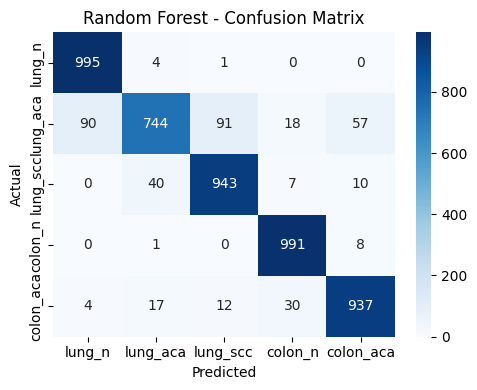

Training time for Random Forest: 58.42 seconds

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9861    0.9940    0.9900      1000
    lung_aca     0.9602    0.9160    0.9376      1000
    lung_scc     0.9388    0.9660    0.9522      1000
     colon_n     0.9881    0.9950    0.9915      1000
   colon_aca     0.9840    0.9860    0.9850      1000

    accuracy                         0.9714      5000
   macro avg     0.9714    0.9714    0.9713      5000
weighted avg     0.9714    0.9714    0.9713      5000

Accuracy: 0.9714
F1 Score (weighted): 0.9712683283702902
Precision (weighted): 0.9714339376830043
Recall (weighted): 0.9714


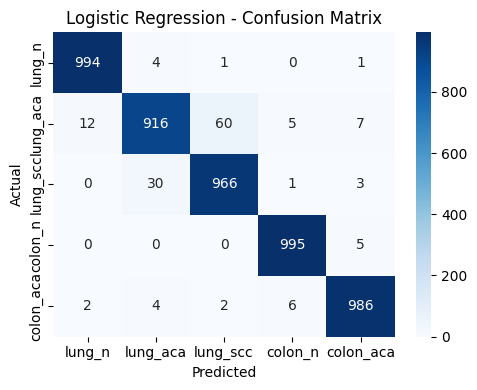

Training time for Logistic Regression: 3.42 seconds

--- SVM (rbf) ---
Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9852    1.0000    0.9926      1000
    lung_aca     0.9917    0.9580    0.9746      1000
    lung_scc     0.9725    0.9920    0.9822      1000
     colon_n     0.9950    0.9970    0.9960      1000
   colon_aca     0.9970    0.9940    0.9955      1000

    accuracy                         0.9882      5000
   macro avg     0.9883    0.9882    0.9882      5000
weighted avg     0.9883    0.9882    0.9882      5000

Accuracy: 0.9882
F1 Score (weighted): 0.9881597870003881
Precision (weighted): 0.9882980147888804
Recall (weighted): 0.9882


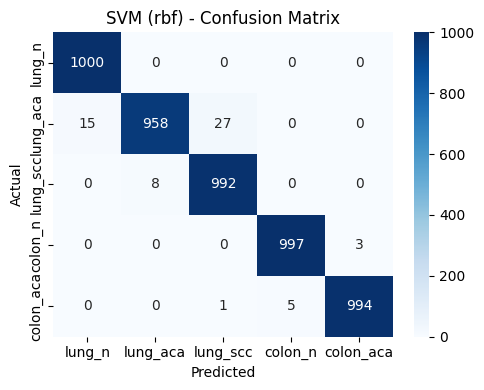

Training time for SVM (rbf): 137.78 seconds

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9097    0.9170    0.9133      1000
    lung_aca     0.6755    0.6660    0.6707      1000
    lung_scc     0.8406    0.8330    0.8368      1000
     colon_n     0.8685    0.9640    0.9137      1000
   colon_aca     0.8055    0.7290    0.7654      1000

    accuracy                         0.8218      5000
   macro avg     0.8199    0.8218    0.8200      5000
weighted avg     0.8199    0.8218    0.8200      5000

Accuracy: 0.8218
F1 Score (weighted): 0.8199810657264903
Precision (weighted): 0.8199474055586848
Recall (weighted): 0.8218


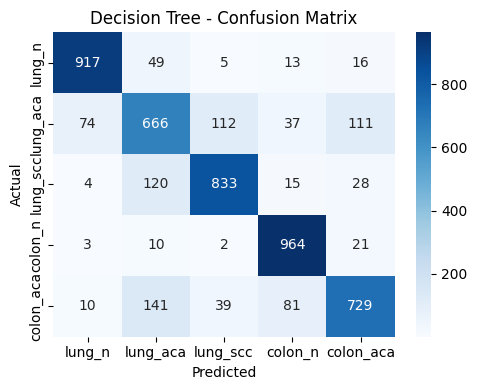

Training time for Decision Tree: 10.84 seconds


c:\Users\burakdogan\Desktop\Ders\DeepLearning\LungColon\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [22:22:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9068    0.9930    0.9480      1000
    lung_aca     0.9063    0.7350    0.8117      1000
    lung_scc     0.9006    0.9420    0.9208      1000
     colon_n     0.9456    0.9900    0.9673      1000
   colon_aca     0.9161    0.9170    0.9165      1000

    accuracy                         0.9154      5000
   macro avg     0.9151    0.9154    0.9129      5000
weighted avg     0.9151    0.9154    0.9129      5000

Accuracy: 0.9154
F1 Score (weighted): 0.9128619235869925
Precision (weighted): 0.9150708233699726
Recall (weighted): 0.9154


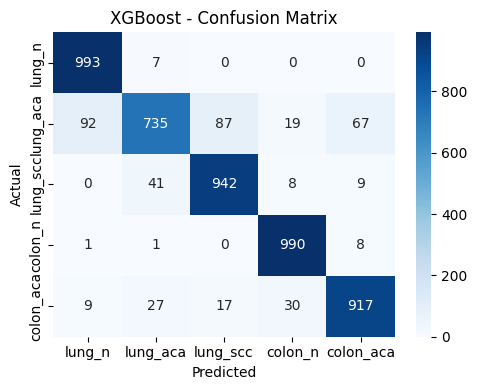

Training time for XGBoost: 39.17 seconds
Saved best model 'SVM (rbf)' for Combined Lung & Colon Cancer Classification as: models/combined_lung_&_colon_cancer_classification_svm_(rbf).joblib
Saved model performance to: models/model_performance.csv


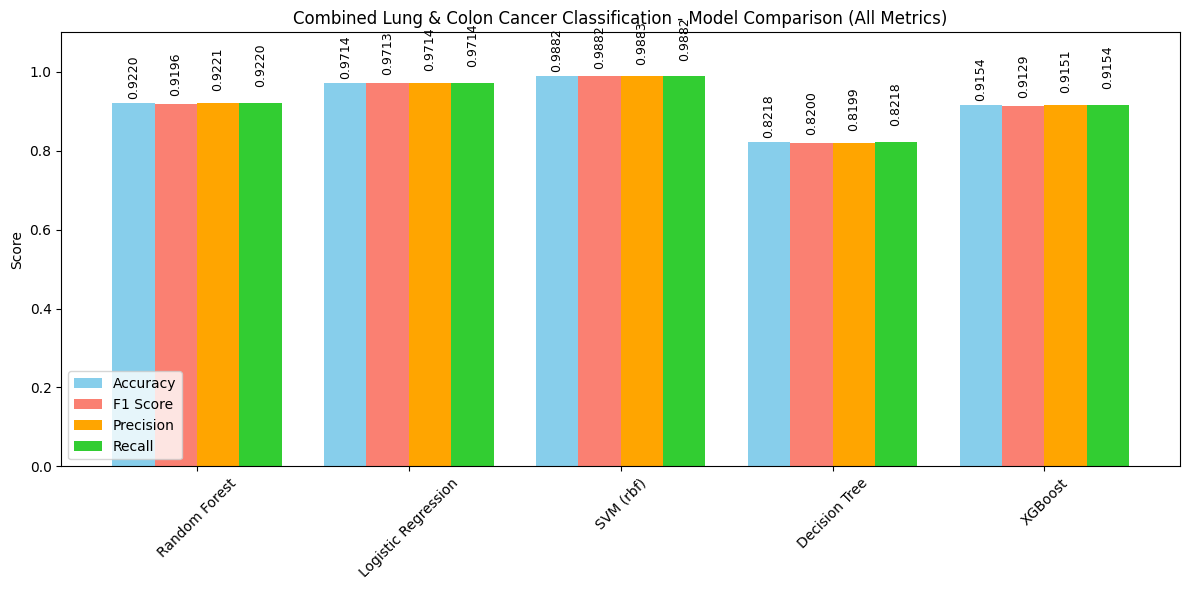

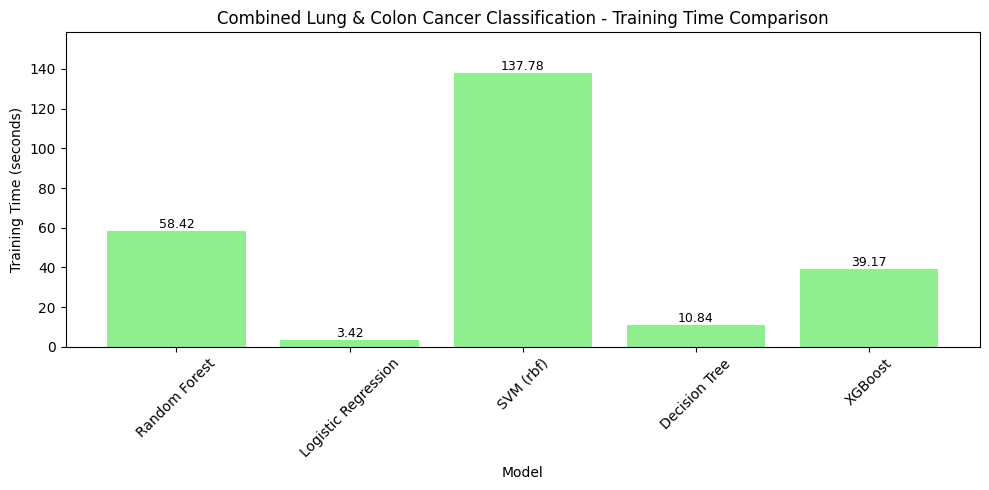


Training Time Table:


,Model,Training Time (s)
0,Random Forest,58.422470
1,Logistic Regression,3.421032
2,SVM (rbf),137.783041
3,Decision Tree,10.838863
4,XGBoost,39.165629


In [90]:
acc_list, f1_list, precision_list, recall_list, training_times, trained_models, X_train_pca, y_train, X_test_pca, y_test = evaluate_cancer_classifiers_all(
    X_train_pca, y_train, X_test_pca, y_test,
    class_names=['lung_n', 'lung_aca', 'lung_scc', 'colon_n', 'colon_aca'],
    task_name="Combined Lung & Colon Cancer Classification"
)


## 5. Ensemble Methods

In [91]:
results = {}


=== Hard Voting Ensemble - Hard Voting Ensemble ===
Selected Top 3 Models for Hard Voting:
 - SVM (rbf): F1 Score = 0.9882
 - Logistic Regression: F1 Score = 0.9713
 - Random Forest: F1 Score = 0.9196

Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9775    0.9990    0.9881      1000
    lung_aca     0.9790    0.9330    0.9555      1000
    lung_scc     0.9590    0.9820    0.9704      1000
     colon_n     0.9920    0.9980    0.9950      1000
   colon_aca     0.9940    0.9890    0.9915      1000

    accuracy                         0.9802      5000
   macro avg     0.9803    0.9802    0.9801      5000
weighted avg     0.9803    0.9802    0.9801      5000



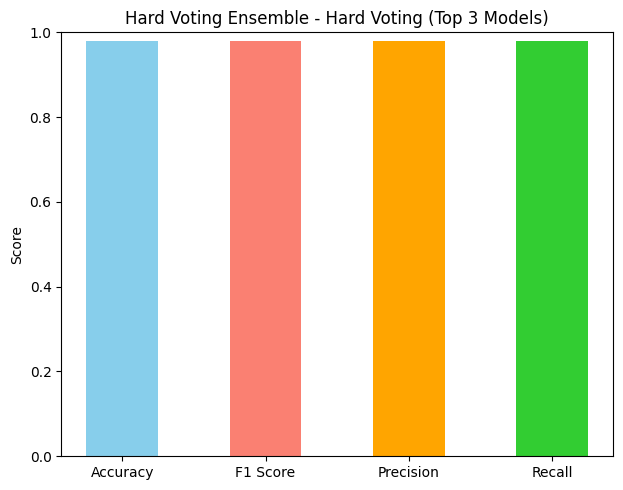

In [92]:
y_pred_hard, metrics_hard = hard_voting_ensemble(
    trained_models, f1_list, X_test_pca, y_test, class_names, task_name="Hard Voting Ensemble"
)
results["Hard Voting"] = metrics_hard


=== Weighted Voting Ensemble - Weighted Voting Ensemble ===
Selected Top 3 Models for Weighted Voting:
 - SVM (rbf): F1 Score = 0.9882
 - Logistic Regression: F1 Score = 0.9713
 - Random Forest: F1 Score = 0.9196
Using model 'SVM (rbf)' with weight 0.9882
Using model 'Logistic Regression' with weight 0.9713
Using model 'Random Forest' with weight 0.9196

Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9920    0.9980    0.9950      1000
    lung_aca     0.9764    0.9530    0.9646      1000
    lung_scc     0.9636    0.9800    0.9717      1000
     colon_n     0.9940    0.9980    0.9960      1000
   colon_aca     0.9940    0.9910    0.9925      1000

    accuracy                         0.9840      5000
   macro avg     0.9840    0.9840    0.9840      5000
weighted avg     0.9840    0.9840    0.9840      5000



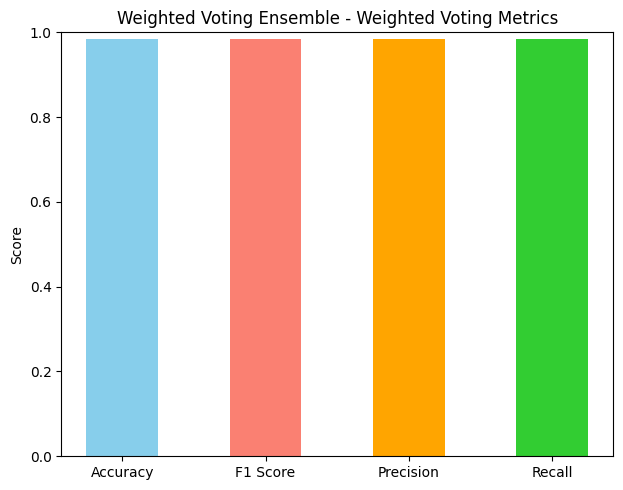

In [93]:
y_pred_weighted, metrics_weighted = weighted_voting_ensemble(
    trained_models, f1_list, X_test_pca, y_test, class_names, task_name="Weighted Voting Ensemble"
)
results["Weighted Voting"] = metrics_weighted



=== Soft Voting Ensemble - Soft Voting Ensemble ===
Top 3 models used in Soft Voting:
 - SVM (rbf): F1 Score = 0.9882
 - Logistic Regression: F1 Score = 0.9713
 - Random Forest: F1 Score = 0.9196

Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9920    0.9980    0.9950      1000
    lung_aca     0.9764    0.9520    0.9641      1000
    lung_scc     0.9627    0.9800    0.9713      1000
     colon_n     0.9940    0.9980    0.9960      1000
   colon_aca     0.9940    0.9910    0.9925      1000

    accuracy                         0.9838      5000
   macro avg     0.9838    0.9838    0.9838      5000
weighted avg     0.9838    0.9838    0.9838      5000



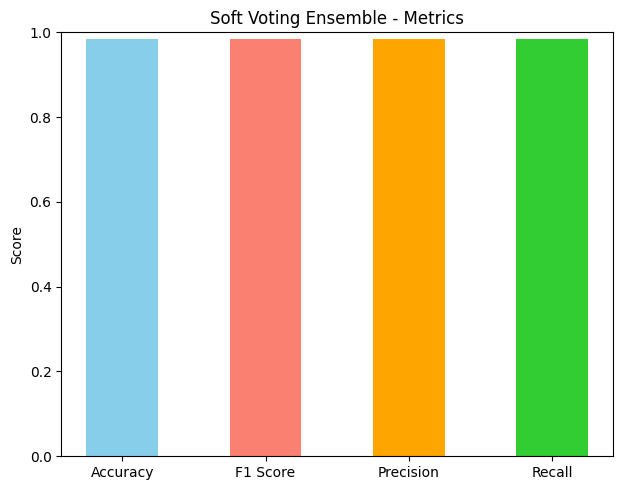

In [94]:
y_pred_soft, metrics_soft = soft_voting_ensemble(
    trained_models, f1_list, X_test_pca, y_test, class_names, task_name="Soft Voting Ensemble"
)
results["Soft Voting"] = metrics_soft



=== Weighted Voting Ensemble - Weighted Voting with Top 3 Models and Custom Weights ===
Selected Top 3 Models:
 - SVM (rbf)
 - Logistic Regression
 - Random Forest
Using model 'SVM (rbf)' with weight 0.7
Using model 'Logistic Regression' with weight 0.2
Using model 'Random Forest' with weight 0.1

Classification Report:
              precision    recall  f1-score   support

      lung_n     0.9881    1.0000    0.9940      1000
    lung_aca     0.9877    0.9600    0.9736      1000
    lung_scc     0.9744    0.9880    0.9811      1000
     colon_n     0.9940    0.9990    0.9965      1000
   colon_aca     0.9970    0.9940    0.9955      1000

    accuracy                         0.9882      5000
   macro avg     0.9882    0.9882    0.9882      5000
weighted avg     0.9882    0.9882    0.9882      5000



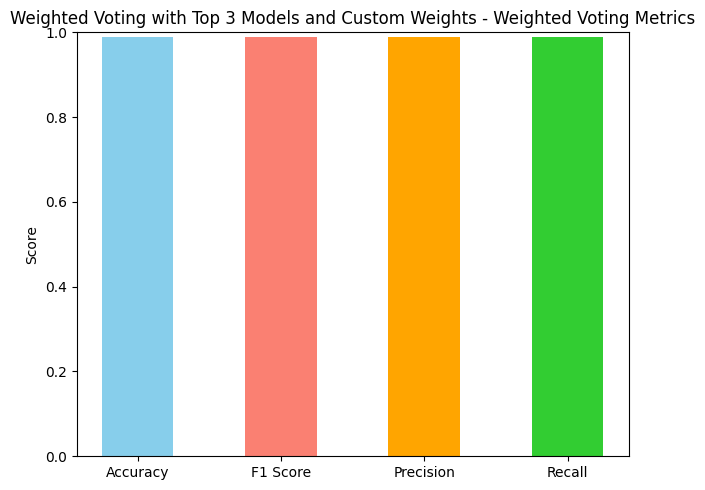

In [109]:
custom_weights = {
    "SVM (rbf)": 0.7,
    "Logistic Regression": 0.2,
    "Random Forest": 0.1,
}

y_pred_weighted_custom, metrics_weighted_custom = weighted_voting_ensemble_custom_weights(
    trained_models, f1_list, X_test_pca, y_test, class_names, custom_weights, top_k=3,
    task_name="Weighted Voting with Top 3 Models and Custom Weights"
)
results["Weighted Voting Custom Weights"] = metrics_weighted_custom


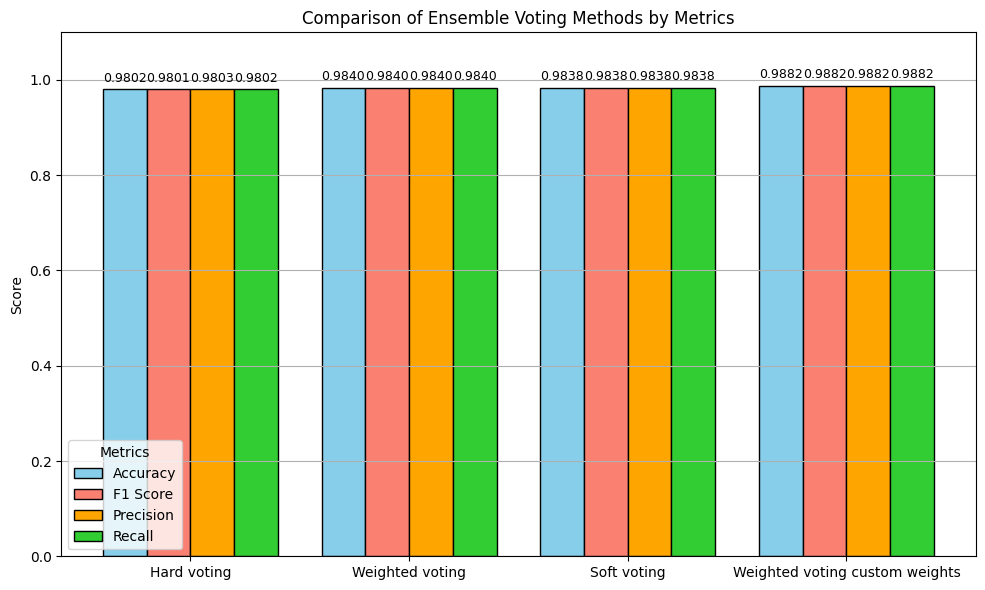

In [110]:
# results: dictionary of dictionaries with structure {voting_method: {metric: value}}
df_metrics = pd.DataFrame(results).T

metrics = df_metrics.columns.tolist()  # ['Accuracy', 'F1 Score', 'Precision', 'Recall']
methods = df_metrics.index.tolist()   # ['hard', 'soft', 'weighted']

x = np.arange(len(methods))  # voting method positions
width = 0.2  # bar width

colors = {
    'Accuracy': 'skyblue',
    'F1 Score': 'salmon',
    'Precision': 'orange',
    'Recall': 'limegreen'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars grouped by method with color by metric (same color for each metric)
for i, metric in enumerate(metrics):
    vals = df_metrics[metric].values
    bars = ax.bar(x + i*width - 1.5*width, vals, width=width, label=metric, color=colors[metric], edgecolor='black')
    
    # Add text labels on top of bars with 4 decimal places
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', 
                ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() + "" for m in methods])
ax.set_ylim(0, 1.1)  # biraz üst boşluk bırakıyoruz
ax.set_ylabel("Score")
ax.set_title("Comparison of Ensemble Voting Methods by Metrics")

ax.legend(title="Metrics")
ax.grid(axis='y')
plt.tight_layout()
plt.show()
